In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import norm
from depth.multivariate import simplicial, halfspace, simplicial, betaSkeleton
from utils.simulate_markov import simulate_arch_1_process
from utils.markov_depth import calculate_markov_tukey_depth, calculate_markov_tukey_depth_for_trajectories, calculate_markov_depth
from utils.depth_functions import tukey_depth_depth_ar_1, tukey_depth_dimension_1
from utils.kernel_estimation import nadaraya_watson_marginal_pdf, nadaraya_watson_marginal_cdf, nadaraya_watson_marginal_cdf_direct, nadaraya_watson_average_marginal_cdf, nadaraya_watson_average_marginal_cdf_direct, nadaraya_watson_average_marginal_pdf
from utils.simulate_markov import simulate_ar1_process, NORMAL_NOISE, UNIFORM_NOISE

In [2]:
# Set up the Seaborn style
sns.set(style="whitegrid")

In [3]:
# Fix the random seed for reproducibility 
random_seed = 15
np.random.seed(random_seed)

In [4]:
# Number of steps on each trajectory
n_steps = 100
# Number of steps of the initial long trajectory.
# Used for the initial kernel estimation.
n_steps_long = n_steps*10
# Number of normal trajectories to simulate
M = 100
# Number of anomalous trajectories to simulate
A = 10

In [5]:
# Parameters of the ARCH(1) process
INITIAL_VALUE = 0.5

def mean_fn(x):
    return 1 / (1 + np.exp(-x))

def volatility_fn(x):
    return norm.pdf(x + 1.2) + 1.5 * norm.pdf(x - 1.2)

We start by simulating a long trajectory of the $ARCH(1)$ process in order to obtain an estimate of its kernel.

In [6]:
# Simulate a long ARCH(1) process, used to estimate the kernel
random_seed +=1
long_arch_trajectory = simulate_arch_1_process(
    n_steps=n_steps_long, 
    m=mean_fn, 
    sigma=volatility_fn, 
    initial_value=INITIAL_VALUE, 
    num_processes=1,
    seed=random_seed,
    noise=NORMAL_NOISE
)[0]

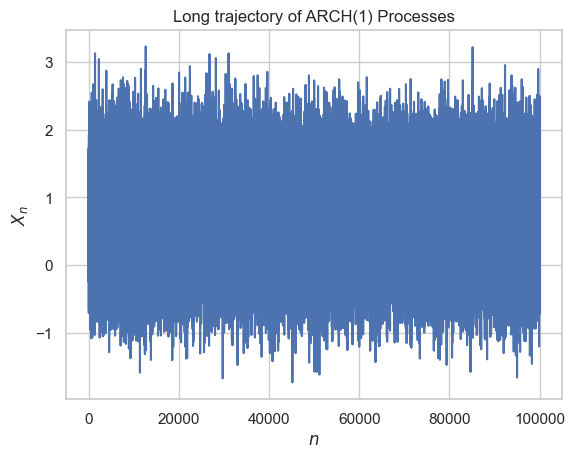

In [7]:
plt.plot(long_arch_trajectory, label=f"Long ARCH(1)")
plt.xlabel(r"$n$")
plt.ylabel(r"$X_n$")
plt.title("Long trajectory of ARCH(1) Processes")
plt.show()

In [8]:
# Simulate  ARCH(1) processes
random_seed +=1
regular_arch_trajectories = simulate_arch_1_process(
    n_steps=n_steps, 
    m=mean_fn, 
    sigma=volatility_fn, 
    initial_value=INITIAL_VALUE, 
    num_processes=M, 
    seed=random_seed,
    noise=NORMAL_NOISE
)

Now we will generate a different ARCH(1) process. We will modify the mean the volatility

In [25]:
def shape_anomaly_volatility_i(x):
    return 1

In [10]:
# Simulate  ARCH(1) process
random_seed +=1
anomalous_arch_trajectories = simulate_arch_1_process(
    n_steps=n_steps, 
    m=mean_fn, 
    sigma=shape_anomaly_volatility_i, 
    initial_value=INITIAL_VALUE, 
    num_processes=A, 
    seed=random_seed,
    noise=NORMAL_NOISE
)


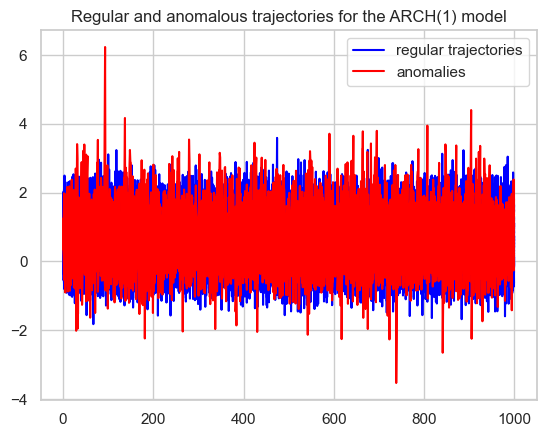

In [11]:
# Plot regular trajectories
for i, trajectory in enumerate(regular_arch_trajectories):
    if i == 0:
        plt.plot(trajectory, color="blue", label="regular trajectories")
    else:
        plt.plot(trajectory, color="blue")

# Plot anomalous trajectories
for i, trajectory in enumerate(anomalous_arch_trajectories):
    if i == 0:
        plt.plot(trajectory, color="red", label="anomalies", alpha=1)
    else:
        plt.plot(trajectory, color="red", alpha=1)
plt.title("Regular and anomalous trajectories for the ARCH(1) model")
plt.legend()
plt.show()

In [12]:
# Bandwidth parameter for the kernel estimation
inverse_bandwidth = np.power(n_steps_long, 1/5)

In [13]:
regular_arch_depths = calculate_markov_tukey_depth_for_trajectories(trajectories=regular_arch_trajectories, long_trajectory=long_arch_trajectory, inverse_bandwidth=inverse_bandwidth)

In [14]:
anomalous_arch_depths = calculate_markov_tukey_depth_for_trajectories(trajectories=anomalous_arch_trajectories, long_trajectory=long_arch_trajectory, inverse_bandwidth=inverse_bandwidth)

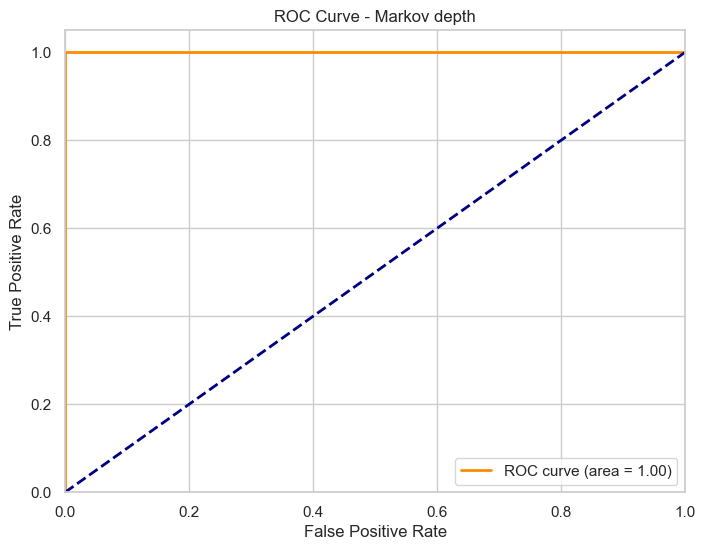

In [15]:
# Because we are labeling regular trajectories as False and anomalous as True,
# and our depth function should be smaller for anomalies, we are using 1-depth 
# for classification.
labels = np.concatenate((np.zeros(M, dtype=bool), np.ones(A, dtype=bool)))
depth_values = np.concatenate((1-regular_arch_depths, 1-anomalous_arch_depths))

fpr, tpr, thresholds = roc_curve(labels, depth_values , pos_label=1)

# Calculate are under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Markov depth')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Now we will apply isolation forest

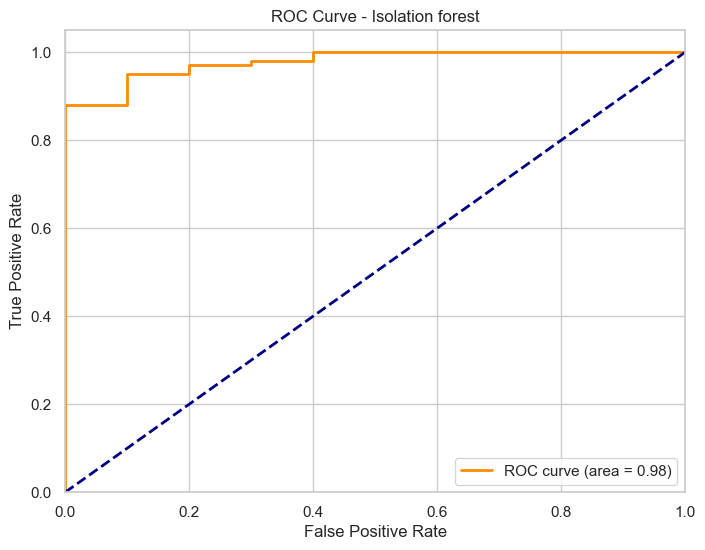

In [16]:
random_seed +=1
all_trajectories = np.concatenate((regular_arch_trajectories, anomalous_arch_trajectories))
# Train Isolation Forest model
model = IsolationForest(contamination=A/M, random_state=random_seed)
model.fit(all_trajectories)

# Calculate anomaly scores
scores = model.decision_function(all_trajectories)

labels = np.concatenate((np.ones(M, dtype=bool), np.zeros(A, dtype=bool)))
depth_values = scores

fpr, tpr, thresholds = roc_curve(labels, scores , pos_label=1)

# Calculate are under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Isolation forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [17]:
clf = LocalOutlierFactor(contamination=A/M)
y_pred = clf.fit_predict(all_trajectories)

In [18]:
y_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1])

Now we will generate a different ARCH(1) process. We will keep the mean and sigma functions, but we will use uniform noise

In [26]:
# Simulate  ARCH(1) process
random_seed +=1
small_anomalous_arch_trajectories = simulate_arch_1_process(
    n_steps=n_steps, 
    m=mean_fn, 
    sigma=shape_anomaly_volatility_i, 
    initial_value=INITIAL_VALUE, 
    num_processes=A, 
    seed=random_seed,
    noise=UNIFORM_NOISE
)

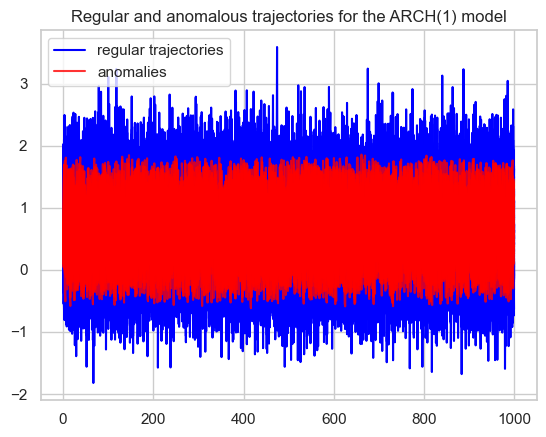

In [27]:
# Plot regular trajectories
for i, trajectory in enumerate(regular_arch_trajectories):
    if i == 0:
        plt.plot(trajectory, color="blue", label="regular trajectories")
    else:
        plt.plot(trajectory, color="blue")

# Plot anomalous trajectories
for i, trajectory in enumerate(small_anomalous_arch_trajectories):
    if i == 0:
        plt.plot(trajectory, color="red", label="anomalies", alpha=0.8)
    else:
        plt.plot(trajectory, color="red", alpha=0.8)
plt.title("Regular and anomalous trajectories for the ARCH(1) model")
plt.legend()
plt.show()

In [28]:
small_anomalous_arch_depths = calculate_markov_tukey_depth_for_trajectories(trajectories=small_anomalous_arch_trajectories, long_trajectory=long_arch_trajectory, inverse_bandwidth=inverse_bandwidth)

In [29]:
small_anomalous_arch_depths

array([0.16751486, 0.16118488, 0.16891385, 0.17210061, 0.16016992,
       0.16388885, 0.16947614, 0.16132486, 0.16736169, 0.17089799])

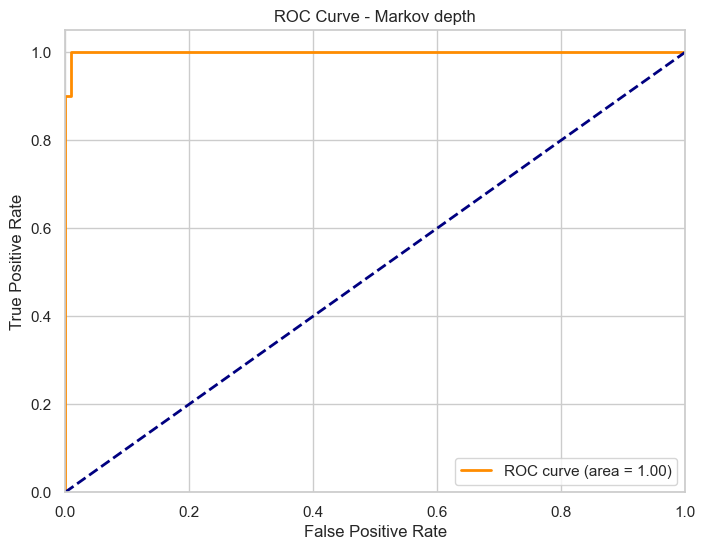

In [30]:
# Because we are labeling regular trajectories as False and anomalous as True,
# and our depth function should be smaller for anomalies, we are using 1-depth 
# for classification.
labels = np.concatenate((np.zeros(M, dtype=bool), np.ones(A, dtype=bool)))
depth_values = np.concatenate((1-regular_arch_depths, 1-small_anomalous_arch_depths))

fpr, tpr, thresholds = roc_curve(labels, depth_values , pos_label=1)

# Calculate are under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Markov depth')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

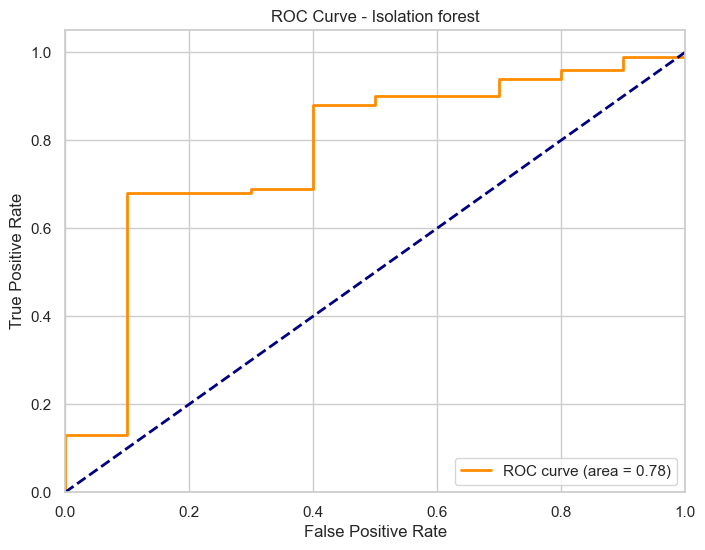

In [31]:
random_seed +=1
all_trajectories = np.concatenate((regular_arch_trajectories, small_anomalous_arch_trajectories))
# Train Isolation Forest model
model = IsolationForest(contamination=A/M, random_state=random_seed)
model.fit(all_trajectories)

# Calculate anomaly scores
scores = model.decision_function(all_trajectories)

labels = np.concatenate((np.ones(M, dtype=bool), np.zeros(A, dtype=bool)))
depth_values = scores

fpr, tpr, thresholds = roc_curve(labels, scores , pos_label=1)

# Calculate are under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Isolation forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()